#Siamese network

1. **setup load data and set parameters**

In [3]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


load the MNIST dataset

In [4]:
(x_train_val, y_train_val) , (x_test, y_test)=keras.datasets.mnist.load_data()
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Define Hyperparameters**

In [5]:
epochs = 10
batch_size = 16
margin=1  #margin for constrastive loss

Define training and validation sets

In [6]:
x_train , x_val = x_train_val[:30000] , x_train_val[30000:]
y_train , y_val = y_train_val[:30000] , y_train_val[30000:]
del x_train_val, y_train_val

Create pairs of images

In [7]:
def make_pairs(x, y):
  num_classes= max(y)+1
  digit_indices=[np.where(y == i)[0] for i in range(num_classes)]
  pairs=[]
  labels=[]

  for idx1 in range(len(x)):
    #add a matching example
    x1 = x[idx1]
    label1 = y[idx1]
    idx2 = random.choice(digit_indices[label1])
    x2=x[idx2]
    pairs.append([x1, x2])
    labels.append(1)

    #add a non_matching example
    label2=random.randint(0, num_classes-1)
    while label2 == label1:
      label2=random.randint(0, num_classes-1)
    idx2 = random.choice(digit_indices[label2])
    x2=x[idx2]
    pairs.append([x1, x2])
    labels.append(0)

  return np.array(pairs), np.array(labels).astype("float32")

pairs_train , labels_train = make_pairs(x_train , y_train)
pairs_val , labels_val = make_pairs(x_val , y_val)
pairs_test , labels_test = make_pairs(x_test , y_test)

Splite the training pairs





In [8]:
x_train_1 = pairs_train[:,0]
x_train_2 = pairs_train[:,1]

Splite the test pairs


In [9]:
x_test_1 = pairs_test[:,0]
x_test_2 = pairs_test[:,1]

Splite the validation pairs

In [10]:
x_val_1 = pairs_val[:,0]
x_val_2 = pairs_val[:,1]

Visualize pairs and their labels

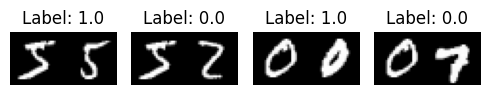

In [12]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))

    # Flatten axes if it's 2D
    if num_row == 1 and num_col == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(to_show):
        ax = axes[i]
        # pair[0] and pair[1] are two images in the pair
        img1 = pairs[i][0].squeeze()
        img2 = pairs[i][1].squeeze()

        # Concatenate the two images side by side
        concatenated = np.hstack([img1, img2])
        ax.imshow(concatenated, cmap='gray')
        ax.axis('off')

        # Build the title
        if test and predictions is not None:
            title = f"True: {labels[i]}, Pred: {int(predictions[i] > 0.5)}"
        else:
            title = f"Label: {labels[i]}"
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Define the model

In [16]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x-y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input=layers.Input((28,28,1))
x=tf.keras.layers.BatchNormalization()(input)
x=layers.Conv2D(4, (5,5), activation="tanh")(x)
x=layers.AveragePooling2D(pool_size=(2,2))(x)
x=layers.Conv2D(16, (5,5), activation="tanh")(x)
x=layers.AveragePooling2D(pool_size=(2,2))(x)
x=layers.Flatten()(x)

x=tf.keras.layers.BatchNormalization()(x)
x=layers.Dense(10, activation= "tanh")(x)
embedding_network= keras.Model(input, x)

input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer= layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer=tf.keras.layers.BatchNormalization()(merge_layer)
output_layer=layers.Dense(1, activation="sigmoid")(normal_layer)
siamese=keras.Model(inputs=[input_1, input_2], outputs=output_layer)

Define Constrastive loss and train

In [18]:
def loss(margin=1):
  def constrastive_loss(y_true, y_pred):
    square_pred=tf.math.square(y_pred)
    margin_square=tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1-y_true) * square_pred + (y_true) * margin_square
    )
  return constrastive_loss


compile the model with constrastive loss

In [21]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 10)        │      5,318 │ input_layer_6[0]… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,324 (20.80 KB)

 Trainable params: 4,808 (18.78 KB)

 Non-trainable params: 516 (2.02 KB)

Train the model

In [22]:
history=siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.8493 - loss: 0.1218 - val_accuracy: 0.9571 - val_loss: 0.0328
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 101s 27ms/step - accuracy: 0.9301 - loss: 0.0533 - val_accuracy: 0.9605 - val_loss: 0.0303
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 122s 22ms/step - accuracy: 0.9450 - loss: 0.0423 - val_accuracy: 0.9761 - val_loss: 0.0191
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9510 - loss: 0.0373 - val_accuracy: 0.9746 - val_loss: 0.0201
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9544 - loss: 0.0352 - val_accuracy: 0.9779 - val_loss: 0.0174
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.9562 - loss: 0.0334 - val_accuracy: 0.9768 - val_loss: 0.0180
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.9586 - loss: 0.0321 - val_accuracy: 0.9778 - val_loss: 0.0172
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9598

Visulization Results

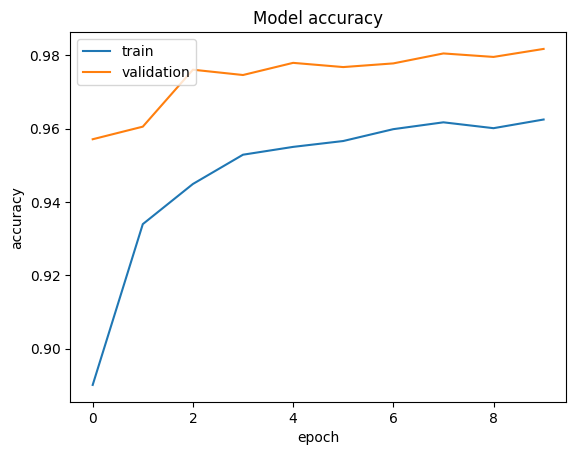

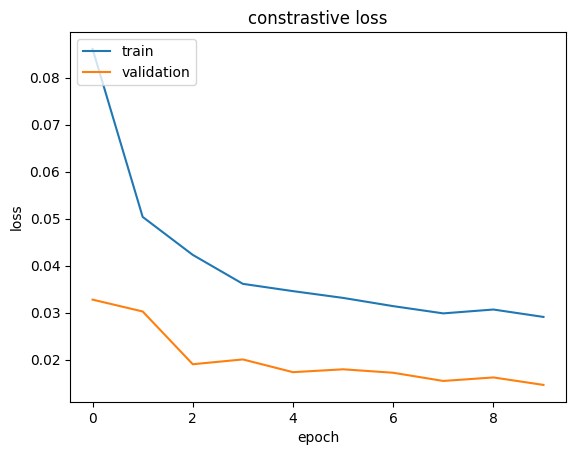

In [23]:
def plt_metric(history, metric, title, has_valid=True):
  plt.plot(history[metric])
  if has_valid:
    plt.plot(history["val_"+metric])
    plt.legend(["train", "validation"], loc="upper left")
  plt.title(title)
  plt.ylabel(metric)
  plt.xlabel("epoch")
  plt.show()

plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

plt_metric(history=history.history, metric="loss", title="constrastive loss")

Evaluate the model

In [24]:
results=siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss , accuracy:", results)

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9838 - loss: 0.0135
test loss , accuracy: [0.012149673886597157, 0.9850000143051147]


visulaize the prediction

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


/tmp/ipython-input-3953626538.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = f"True: {labels[i]}, Pred: {int(predictions[i] > 0.5)}"


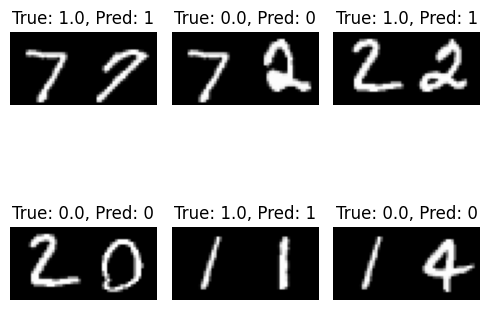

In [25]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=6, num_col=3, predictions=predictions, test=True)